# Predicting NBA All-Stars

## Motivation

The National Basketball Association (NBA) is a professional basketball league in North America, currently composed of 30 teams (29 in the US and 1 in Canada). It is the best basketball league in the world attracting the best players from around the world. Every year, around the midpoint of the season in February, they organize an exhibition game called the All-Star game. 24 of the best players in the league are chosen as the All-Stars to play in this game as voted by fans, media, fellow players and coaches. 

Being an all-star is regarded as a great achievement and therefore has been used as a metric in ranking the players historically. Usually team success and player performance are used by the voters in their selections. The goal of this study is to gather pre-all-star break data from the official NBA stats website to see if we can develop a machine learning model that can predict this year's all-stars based on per game stats.   

## NBA All-Star Selection Process

The All-Star Selection process is best summarized in the Wikipedia article: 

https://en.wikipedia.org/wiki/NBA_All-Star_Game

"... The starting lineup for each squad is selected by a combination of fan, player, and media voting, while head coaches choose the reserves, seven players from their respective conferences, so each side has a 12-man roster... If a selected player cannot participate because of injury, the NBA commissioner selects a replacement... 

... The starting five from each conference consists of three frontcourt players and two guards, selected by a combination of fan, player, and media voting. In 2017, the NBA moved from a pure fan vote to a weighted process wherein fan voting accounts for 50%, with player and media voting account for 25% each. Prior to 2013, fans selected two forwards and one center instead of generic frontcourt players ...

... NBA coaches vote for the reserves for their respective conferences, but they cannot choose players from their own team. Each coach selects two guards, three frontcourt players and two wild cards, with each selected player ranked in order of preference within each category ..."

Based on these selection rules, it is clear that we need information on the positions and conferences in addition to player performance and team stats.

In [1]:
# Importing libraries
import os, sys
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Configure libraries
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

# Add base to path
sys.path.append('..')
sys.path.append('../../')

# Initialize dirs
data_dir = 'data'
input_data_dir = os.path.join(data_dir, 'input')
output_data_dir = os.path.join(data_dir, 'output')

The required data was collected using 2 different web scraping techniques from the official NBA Stats and the RealGM websites. The explanation and the codes can be found in the notebook "nba_stats_scraping.ipynb" which is located in the same repository:

github.com/ibraeksi/nba-analytics/nba_allstar_stats_scraping.ipynb

The pre all-star break stats are only available starting from the 1996-97 season. This raw data was processed and filtered to use in the machine learning algorithms ın the following notebook:

github.com/ibraeksi/nba-analytics/historical_allstar_data_preprocessing.ipynb

In [2]:
nba = pd.read_csv(os.path.join(output_data_dir, 'nba_allstar_processed_data.csv'))

## Feature Engineering

In order to make sure these values are equally weighted within our model, we'll need to rescale the data. We also need to rank these players within their positions in their respective conferences in order to fit the selection criteria. We can't ask our model to identify all 24 players as guards or from western conference only. As a reminder, the selection process is:

Prior to 2013:

    East --> 4 Guards, 2 Forwards, 1 Center, 3 Frontcourt (F or C) and 2 Wildcards(G, F or C) 
    West --> 4 Guards, 2 Forwards, 1 Center, 3 Frontcourt (F or C) and 2 Wildcards(G, F or C)

Since 2013:

    East --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C) 
    West --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C)

Therefore we can use percentile ranks among certain groups to find the best-performing players for each category:

In [3]:
nba['POS'].value_counts()

POS
G      1653
F      1237
C       396
G-F     391
C-F     267
F-C     262
F-G     191
Name: count, dtype: int64

In [4]:
pos_type = ['G', 'F', 'C']
conf_type = ['E', 'W']

for year in range(1997,2025):
    for conf in conf_type:
        for pos in pos_type:
            nba_year = nba[nba['YEAR'] == year]
            nba_group = nba_year[(nba_year['POS'].str.contains(pos)) & (nba_year['CONF'] == conf)]
            nba.loc[nba['YEAR'] == year, 'PTS_' + conf + pos] = nba_group['PTS'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'REB_' + conf + pos] = nba_group['REB'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'AST_' + conf + pos] = nba_group['AST'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'STL_' + conf + pos] = nba_group['STL'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'BLK_' + conf + pos] = nba_group['BLK'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FP_' + conf + pos] = nba_group['NBA_FANTASY_PTS'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'TO_' + conf + pos] = nba_group['TOV'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'W_PCT_' + conf + pos] = nba_group['W_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FG_PCT_' + conf + pos] = nba_group['FG_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FG3_PCT_' + conf + pos] = nba_group['FG3_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FT_PCT_' + conf + pos] = nba_group['FT_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'DD_' + conf + pos] = nba_group['DD2'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'TD_' + conf + pos] = nba_group['TD3'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'PM_' + conf + pos] = nba_group['PLUS_MINUS'].rank(pct = True)

nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,WT,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,GP_PCT,PTS_EG,REB_EG,AST_EG,STL_EG,BLK_EG,FP_EG,TO_EG,W_PCT_EG,FG_PCT_EG,FG3_PCT_EG,FT_PCT_EG,DD_EG,TD_EG,PM_EG,PTS_EF,REB_EF,AST_EF,STL_EF,BLK_EF,FP_EF,TO_EF,W_PCT_EF,FG_PCT_EF,FG3_PCT_EF,FT_PCT_EF,DD_EF,TD_EF,PM_EF,PTS_EC,REB_EC,AST_EC,STL_EC,BLK_EC,FP_EC,TO_EC,W_PCT_EC,FG_PCT_EC,FG3_PCT_EC,FT_PCT_EC,DD_EC,TD_EC,PM_EC,PTS_WG,REB_WG,AST_WG,STL_WG,BLK_WG,FP_WG,TO_WG,W_PCT_WG,FG_PCT_WG,FG3_PCT_WG,FT_PCT_WG,DD_WG,TD_WG,PM_WG,PTS_WF,REB_WF,AST_WF,STL_WF,BLK_WF,FP_WF,TO_WF,W_PCT_WF,FG_PCT_WF,FG3_PCT_WF,FT_PCT_WF,DD_WF,TD_WF,PM_WF,PTS_WC,REB_WC,AST_WC,STL_WC,BLK_WC,FP_WC,TO_WC,W_PCT_WC,FG_PCT_WC,FG3_PCT_WC,FT_PCT_WC,DD_WC,TD_WC,PM_WC
count,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,4397.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1133.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,1217.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,475.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1102.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,1131.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000,450.0000
mean,27.3759,45.7375,23.0953,22.6423,0.5031,31.2466,5.3148,11.5960,0.4592,1.1010,3.0378,0.2977,2.6627,3.4384,0.7699,1.3401,4.1462,5.4861,3.2215,1.9087,1.0058,0.6137,0.6640,2.4263,2.1634,14.3903,0.5393,28.7488,7.0064,0.2329,27.4323,221.8531,1875.2870,1.0969,15.1610,2004.9993,2011.7159,51.7209,26.0957,25.6252,0.5046,0.1494,0.8850,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5107,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5274,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5118,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5115,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289,0.5289
std,4.0729,8.5086,8.5031,8.1225,0.1552,4.4233,1.9066,3.9888,0.0539,0.8869,2.2949,0.1415,1.6050,1.9924,0.0935,0.9691,1.8440,2.6285,2.1041,0.7741,0.4194,0.5890,0.3249,0.6031,1.7851,5.3930,3.6710,8.5790,8.9132,1.2158,8.1449,26.9005,492.8981,0.4852,14.0778,8.4792,7.6474,5.9959,8.4350,8.4590,0.1519,0.3565,0.1350,0.2887,0.2883,0.2886,0.2871,0.2825,0.2887,0.2882,0.2886,0.2886,0.2887,0.2887,0.2797,0.1511,0.2886,0.2887,0.2886,0.2884,0.2868,0.2869,0.2887,0.2881,0.2886,0.2887,0.2871,0.2887,0.2869,0.1363,0.2886,0.2883,0.2882,0.2877,0.2847,0.2873,0.2885,0.2872,0.2884,0.2885,0.2543,0.2885,0.2876,0.1267,0.2884,0.2887,0.2884,0.2886,0.2872,0.2832,0.2887,0.2882,0.2886,0.2886,0.2887,0.2887,0.2811,0.1575,0.2886,0.2887,0.2886,0.2883,0.2869,0.2870,0.2887,0.2880,0.2886,0.2887,0.2880,0.2887,0.2868,0.1420,0.2887,0.2884,0.2882,0.2877,0.2854,0.2873,0.2885,0.2872,0.2883,0.2884,0.2600,0.2884,0.2877,0.1426,0.2884
min,19.0000,13.0000,2.0000,2.0000,0.0680,24.0000,1.2000,2.90

Now we have the most well-known statistical categories on a 0-1 scale. The resulting missing values can be filled with 0 to indicate that they have no weight for the given player.

In [5]:
nba = nba.fillna(0)
nba[nba['YEAR'] == 2021].sort_values('PTS_WF', ascending = False).head()

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF,GP_PCT,PTS_EG,REB_EG,AST_EG,STL_EG,BLK_EG,FP_EG,TO_EG,W_PCT_EG,FG_PCT_EG,FG3_PCT_EG,FT_PCT_EG,DD_EG,TD_EG,PM_EG,PTS_EF,REB_EF,AST_EF,STL_EF,BLK_EF,FP_EF,TO_EF,W_PCT_EF,FG_PCT_EF,FG3_PCT_EF,FT_PCT_EF,DD_EF,TD_EF,PM_EF,PTS_EC,REB_EC,AST_EC,STL_EC,BLK_EC,FP_EC,TO_EC,W_PCT_EC,FG_PCT_EC,FG3_PCT_EC,FT_PCT_EC,DD_EC,TD_EC,PM_EC,PTS_WG,REB_WG,AST_WG,STL_WG,BLK_WG,FP_WG,TO_WG,W_PCT_WG,FG_PCT_WG,FG3_PCT_WG,FT_PCT_WG,DD_WG,TD_WG,PM_WG,PTS_WF,REB_WF,AST_WF,STL_WF,BLK_WF,FP_WF,TO_WF,W_PCT_WF,FG_PCT_WF,FG3_PCT_WF,FT_PCT_WF,DD_WF,TD_WF,PM_WF,PTS_WC,REB_WC,AST_WC,STL_WC,BLK_WC,FP_WC,TO_WC,W_PCT_WC,FG_PCT_WC,FG3_PCT_WC,FT_PCT_WC,DD_WC,TD_WC,PM_WC
3784,Luka Dončić,DAL,22.0000,32,17,15,0.5310,35.2000,10.0000,20.9000,0.4780,2.7000,7.4000,0.3570,6.0000,8.0000,0.7570,0.8000,7.6000,8.4000,9.0000,4.2000,1.0000,0.7000,0.9000,2.0000,5.9000,28.6000,0.8000,53.1000,16,7,52.0000,F-G,6-6,230.0000,Real Madrid,Slovenia,2018.0000,1.0000,3.0000,2018,2021,34.0000,18.0000,16.0000,0.5290,0.0000,W,0.9412,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9592,1.0000,1.0000,0.6020,0.9082,1.0000,1.0000,0.4898,0.7857,0.3673,0.2245,1.0000,1.0000,0.5510,1.0000,0.9333,1.0000,0.7444,0.6000,1.0000,1.0000,0.3778,0.5778,0.4667,0.4111,1.0000,1.0000,0.5111,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3761,Kawhi Leonard,LAC,30.0000,30,20,10,0.6670,34.6000,9.6000,18.7000,0.5110,2.0000,5.2000,0.3870,5.5000,6.3000,0.8730,0.9000,5.3000,6.3000,4.9000,1.9000,1.5000,0.5000,0.5000,1.6000,4.3000,26.6000,7.9000,45.6000,5,0,43.8000,F,6-7,225.0000,San Diego State,USA,2011.0000,1.0000,15.0000,2011,2021,38.0000,24.0000,14.0000,0.6320,1.0000,W,0.7895,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9778,0.6000,0.8889,0.9778,0.3444,0.9556,0.7667,0.8222,0.8000,0.7444,0.8444,0.6889,0.4667,0.9778,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3780,LeBron James,LAL,36.0000,36,24,12,0.6670,34.6000,9.7000,19.1000,0.5090,2.4000,6.7000,0.3580,4.0000,5.8000,0.6920,0.6000,7.4000,8.0000,7.8000,3.8000,1.1000,0.6000,0.6000,1.6000,4.8000,25.8000,6.5000,48.6000,15,3,47.5000,F,6-9,250.0000,St. Vincent-St. Mary HS (OH),USA,2003.0000,1.0000,1.0000,2003,2021,37.0000,24.0000,13.0000,0.6490,1.0000,W,0.9730,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9556,0.8667,0.9556,0.8000,0.4889,0.9778,0.9778,0.8222,0.7778,0.5000,0.1778,0.9778,0.9778,0.9556,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3842,Zion Williamson,NOP,20.0000,34,15,19,0.4410,33.1000,9.9000,16.1000,0.6140,0.2000,0.6000,0.3160,5.7000,8.2000,0.6950,2.7000,4.5000,7.2000,3.4000,2.6000,0.9000,0.7000,2.1000,2.4000,5.7000,25.6000,0.1000,41.8000,9,0,39.7000,F,6-6,284.0000,Duke,USA,2019.0000,1.0000,1.0000,201

We can train a logistic regression model using all of our new scaled features to see how well they perform in predicting the all-stars. We can limit the example on guards for clarity:

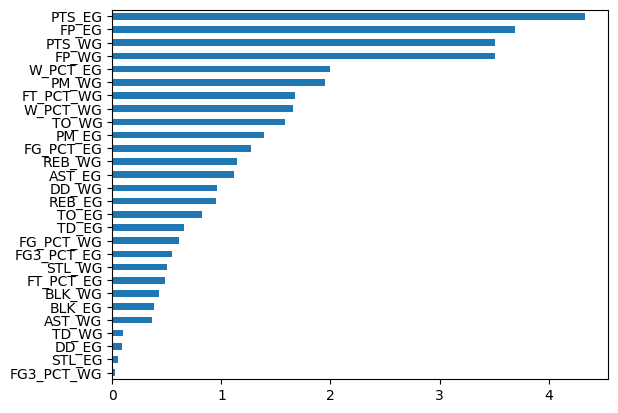

In [6]:
columns = ['PTS_WG', 'REB_WG', 'AST_WG', 'STL_WG', 'BLK_WG', 'FP_WG',
          'PTS_EG', 'REB_EG', 'AST_EG', 'STL_EG', 'BLK_EG', 'FP_EG',
          'W_PCT_WG', 'W_PCT_EG', 'PM_WG', 'PM_EG', 'FG_PCT_WG', 'FG_PCT_EG',
          'FG3_PCT_WG', 'FG3_PCT_EG', 'FT_PCT_WG', 'FT_PCT_EG', 
           'DD_WG', 'DD_EG', 'TD_WG', 'TD_EG', 'TO_WG', 'TO_EG']

nba_guard = nba[nba['POS'].str.contains('G')]

lr = LogisticRegression()
lr.fit(nba_guard[columns], nba_guard['ALLSTAR'])
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=nba_guard[columns].columns)
feature_importance.abs().sort_values().plot.barh()
plt.show()

As seen, points, winning percentage and plus-minus seem to be 3 best features on the guard dataset. Also we can use Fantasy Points (FP) instead of the other traditional stats individually since it is a combination of them:

    FP = Pts: 1 Rebs: 1.2 Ast: 1.5 Stl: 3 Blocks: 3 TO: -1

Therefore we can modify the dataframe to include accordingly:

In [7]:
# Create a "clean" dataframe
nbamod = nba.copy().reset_index(drop=True)
# Delete all columns containing the lesser traditional stats
del_col = ['REB', 'AST', 'STL', 'BLK', 'TO', 'FT', 'FG', 'DD', 'TD']
for col in del_col:
    nbamod.drop(nbamod.columns[nbamod.columns.str.contains(col)], axis=1, inplace=True)

We can delete the original numerical columns:

In [8]:
# Original player stats
nbamod.drop(nbamod.columns[1:14], axis=1, inplace=True)
# Original team stats
nbamod.drop(nbamod.columns[nbamod.columns.str.contains('TEAM')], axis=1, inplace=True)

We can also get rid of player bio data like draft or country:

In [9]:
# Player bio data
nbamod.drop(nbamod.columns[2:9], axis=1, inplace=True)

Now we have the following remaining features:

In [10]:
nbamod.dtypes.value_counts()

float64    26
object      3
int64       1
Name: count, dtype: int64

Our aim is to end up with all numerical columns since they can be used natively with scikit-learn. So we need to check the object columns before converting them to numerical:

In [11]:
object_cols = nbamod.select_dtypes(include=['object'])
for col in object_cols:
    print(nbamod[col].value_counts())

PLAYER_NAME
LeBron James        21
Chris Paul          19
Dirk Nowitzki       19
Carmelo Anthony     18
Tim Duncan          17
                    ..
Jonathan Kuminga     1
Naji Marshall        1
Torrey Craig         1
Quentin Grimes       1
Zach Collins         1
Name: count, Length: 955, dtype: int64
POS
G      1653
F      1237
C       396
G-F     391
C-F     267
F-C     262
F-G     191
Name: count, dtype: int64
CONF
E    2237
W    2160
Name: count, dtype: int64


We will only use PLAYER_NAME to check the predictions visually, they won't be part of the features to train. We can rename it for short:

In [12]:
nbamod = nbamod.rename(columns={"PLAYER_NAME": "PLAYER"})

As seen POS feature has 7 unique values, however upon closer inspection, we see that G-F and F-G should be regarded as the same. Therefore we need to first rename those positions:

In [13]:
nbamod['POS'] = nbamod['POS'].replace(['G-F', 'F-G'], 'GF')
nbamod['POS'] = nbamod['POS'].replace(['C-F', 'F-C'], 'FC')
nbamod['POS'].value_counts()

POS
G     1653
F     1237
GF     582
FC     529
C      396
Name: count, dtype: int64

Now that we have truly unique values, we can convert these columns to categorical:

In [14]:
cat_columns = ['POS', 'CONF']
dummy_nba = pd.get_dummies(nbamod[cat_columns])
nbamod = pd.concat([nbamod, dummy_nba], axis=1)

In [15]:
nbamod.head()

,PLAYER,POS,YEAR,ALLSTAR,CONF,GP_PCT,PTS_EG,FP_EG,W_PCT_EG,PM_EG,PTS_EF,FP_EF,W_PCT_EF,PM_EF,PTS_EC,FP_EC,W_PCT_EC,PM_EC,PTS_WG,FP_WG,W_PCT_WG,PM_WG,PTS_WF,FP_WF,W_PCT_WF,PM_WF,PTS_WC,FP_WC,W_PCT_WC,PM_WC,POS_C,POS_F,POS_FC,POS_G,POS_GF,CONF_E,CONF_W
0,Allan Houston,G,1997,0.0000,E,1.0000,0.5263,0.1184,0.7632,0.5263,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,True,False,True,False
1,Allen Iverson,G,1997,0.0000,E,0.8913,0.9474,0.9737,0.1053,0.0526,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,True,False,True,False
2,Alonzo Mourning,C,1997,1.0000,E,0.9583,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.9000,0.9000,0.9500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,False,False,False,True,False
3,Andrew Lang,C,1997,0.0000,E,0.8511,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500,0.0500,0.3500,0.4500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,False,False,False,True,False
4,Anfernee Hardaway,GF,1997,1.0000,E,0.4773,0.8289,0.8421,0.9474,0.8684,0.9216,0.9020,0.9412,0.8824,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,False,True,True,False


In [16]:
nbamod.shape

(4397, 37)

## Error Metric

We now have a filtered dataset with engineered features. Before diving in and selecting an algorithm to apply to the data, we should select an error metric. As stated earlier, the usual accuracy metric will not work here since we have class imbalance, meaning there are still 6 non all-stars for every all-star. So even if we predicted every player a non all-star, we still get a high accuracy. 

In this case, we don't want to use accuracy and should instead use metrics that tell us the number of false positives and false negatives. This means that we should optimize for high recall (true positive rate) and low fall-out (false positive rate). We can calculate false positive rate and true positive rate, using the numbers of true positives, true negatives, false negatives, and false positives. 

We can start with logistic regression:

In [17]:
cols = nbamod.columns
train_cols = cols.drop(['PLAYER', 'YEAR', 'ALLSTAR', 'POS', 'CONF'])
features = nbamod[train_cols]
target = nbamod['ALLSTAR']

# Instantiate model object.
lr = LogisticRegression()

# Make predictions using 10-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=10)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 0)
tn = len(predictions[tn_filter])

# Compute confusion matrix to show a summary
cm = confusion_matrix(target, predictions)

print(cm)

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print('True Positive Rate: {}'.format(tpr))
print('False Positive Rate: {}'.format(fpr))

score = f1_score(nbamod['ALLSTAR'], predictions)
print('F1 Score: {}'.format(score))

[[3664   76]
 [ 242  415]]
True Positive Rate: 0.6316590563165906
False Positive Rate: 0.020320855614973262
F1 Score: 0.7229965156794426


We can see that the model achieves an accuracy score of 72% which is a good start. Our true positive rate is around 63%, and our false positive rate is around 0.02%. So the model does a good job of identifying who is not an all-star, but it can only identify about 63% of the all-stars. 

Let's try a weighted approach to penalize certain rows more as a way to counter class imbalance. Setting class_weight to balanced will automatically set a penalty based on the number of 1s and 0s in the column (in our case it will be about 5.5):

In [18]:
# Instantiate model object with class weight.
lr = LogisticRegression(class_weight='balanced')

# Make predictions using 10-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=10)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 0)
tn = len(predictions[tn_filter])

# Compute confusion matrix to show a summary
cm = confusion_matrix(target, predictions)

print(cm)

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print('True Positive Rate: {}'.format(tpr))
print('False Positive Rate: {}'.format(fpr))

score = f1_score(nbamod['ALLSTAR'], predictions)
print('F1 Score: {}'.format(score))

[[3283  457]
 [  38  619]]
True Positive Rate: 0.9421613394216134
False Positive Rate: 0.12219251336898396
F1 Score: 0.7143681477207156


We can see that the true positive rate is increased to 94%, but the number of false positives are also scaled upwards resulting in a 12% rate meaning that the model overcorrected so we have about 457 predicted all-stars who were not chosen so in reality. F1 score also represents this as it decreased to 71%.

## Algorithm Selection and Tuning

Instead of testing parameters and weights one by one to find the best-performing model, we can use GridSearchCV to go through 3 different algorithms with varying hyperparameters:

In [19]:
cols = nbamod.columns
train_cols = cols.drop(['PLAYER', 'YEAR', 'ALLSTAR', 'POS', 'CONF'])
features = nbamod[train_cols]
target = nbamod['ALLSTAR']

models = [
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyperparameters':
            {
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'class_weight': [None, 'balanced', {0: 3, 1: 1}],
                'max_iter': [200]
            }
    },
    {
        'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
            {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
    },
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(random_state=1),
        'hyperparameters':
            {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5],
                'class_weight': [None, 'balanced', {0: 3, 1: 1}]
            }
    }
]

for model in models:
    print(model['name'])
    print('-'*len(model['name']))
    
    grid = GridSearchCV(model['estimator'],
                        param_grid=model['hyperparameters'],
                        cv=10, scoring='f1')
    grid.fit(features, target)
    model['best_params'] = grid.best_params_
    model['best_score'] = grid.best_score_
    model['best_model'] = grid.best_estimator_
    
    print("Best Score: {}".format(model["best_score"]))
    print("Best Parameters: {}".format(model["best_params"]))
    
    predictions = cross_val_predict(model['best_model'], features, target, cv=10)
    cm = confusion_matrix(target, predictions)
    
    print("Best Predictions:\n{}\n".format(cm))

LogisticRegression
------------------
Best Score: 0.7217964384405007
Best Parameters: {'class_weight': None, 'max_iter': 200, 'solver': 'lbfgs'}
Best Predictions:
[[3664   76]
 [ 242  415]]

KNeighborsClassifier
--------------------
Best Score: 0.7625335063177209
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Best Predictions:
[[3613  127]
 [ 173  484]]

RandomForestClassifier
----------------------
Best Score: 0.7595911289299452
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
Best Predictions:
[[3549  191]
 [ 137  520]]



In [20]:
nbamod['ALLSTAR'].value_counts()

ALLSTAR
0.0000    3740
1.0000     657
Name: count, dtype: int64

As seen, the best model predicts 657 all-stars which is the correct number of actual all-stars. However the number of false negatives at around 130. This would mean that about 6 players out of 25 per year get misidentified with other players which could be an acceptable result considering the biases in the voting process. 

For instance, we can compare the predictions vs. the actual selection from last year:

In [21]:
nbamod['PREDICT'] = predictions
nbamod[(nbamod['YEAR'] == 2024) & (nbamod['PREDICT'] == 1) & (nbamod['ALLSTAR'] == 1)]['PLAYER']

4218              Anthony Davis
4219            Anthony Edwards
4249             Damian Lillard
4264               Devin Booker
4268           Donovan Mitchell
4278      Giannis Antetokounmpo
4295              Jalen Brunson
4306               Jayson Tatum
4310                Joel Embiid
4321              Julius Randle
4323         Karl-Anthony Towns
4324              Kawhi Leonard
4329               Kevin Durant
4341               LeBron James
4366                Paul George
4376    Shai Gilgeous-Alexander
4378              Stephen Curry
4384                 Trae Young
4388          Tyrese Haliburton
4389               Tyrese Maxey
Name: PLAYER, dtype: object

In [22]:
nbamod[(nbamod['YEAR'] == 2024) & (nbamod['PREDICT'] == 1) & (nbamod['ALLSTAR'] == 0)]['PLAYER']

4215        Alperen Sengun
4242         Chet Holmgren
4252          De'Aaron Fox
4267      Domantas Sabonis
4302          James Harden
4304         Jarrett Allen
4335    Kristaps Porziņģis
4343           Luka Dončić
4357          Nikola Jokić
Name: PLAYER, dtype: object

In [23]:
nbamod[(nbamod['YEAR'] == 2024) & (nbamod['PREDICT'] == 0) & (nbamod['ALLSTAR'] == 1)]['PLAYER']

4223       Bam Adebayo
4305      Jaylen Brown
4363    Paolo Banchero
4374    Scottie Barnes
Name: PLAYER, dtype: object

Looking at the names, we can see that the current model overvalues good offensive players on winning teams more than defensive-minded players that may not average as many points. But the predicted names are either former all-stars or players considered to be near that level. 

In [24]:
nbamod[(nbamod['YEAR'] == 2024) & (nbamod['PREDICT'] == 1)]['POS'].value_counts()

POS
G     12
FC     7
F      5
C      3
GF     2
Name: count, dtype: int64

In [25]:
nbamod[(nbamod['YEAR'] == 2024) & (nbamod['PREDICT'] == 1)]['CONF'].value_counts()

CONF
W    17
E    12
Name: count, dtype: int64

The predictions also seem to be balanced in terms of positions and conferences. The model predicts 14 Backcourt(Guard) and 13 Frontcourt(Forward or Center) players as the teams usually consist of equal amounts of each. It needs to be noted that the rosters normally consist of 12 players for conference, but there are some injury replacements increasing the number of all-stars.

## Predicting the 2025 All-Stars

We can now move on to predicting the 2025 all-stars based on the current season's data. The current data was collected from NBA Stats website as explained in the first section:

In [26]:
bio = pd.read_csv(os.path.join(input_data_dir, 'player_bio_historical.csv'))
pl_current = pd.read_csv(os.path.join(input_data_dir, 'pre_allstar_player_stats_2025.csv'))
tm_current = pd.read_csv(os.path.join(input_data_dir, 'pre_allstar_team_stats_2025.csv'))

In [27]:
print(pl_current.shape)
pl_current.columns[pl_current.isna().any()].tolist()

(524, 67)


[]

We can see that there are a total of 533 players who appeared in a game this season and there is no data missing. So the dataset has to go through the same data transformation steps as the training dataset:

In [28]:
# Add player positions
pl_current['POS'] = pl_current['PLAYER_ID'].map(bio.set_index('PERSON_ID')['POSITION'])

In [29]:
# Add year column
pl_current['YEAR'] = pl_current['SEASON'].str.split('-').str[0].astype('int64') + 1
tm_current['YEAR'] = tm_current['SEASON'].str.split('-').str[0].astype('int64') + 1

pl_current.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,YEAR
0,1630639,A.J. Lawson,A.J.,1610612761,TOR,24.0000,4,1,3,0.2500,3.8000,1.0000,2.0000,0.5000,0.5000,1.3000,0.4000,0.3000,0.8000,0.3330,0.3000,0.5000,0.8000,0.0000,0.0000,0.0000,0.0000,0.3000,0.0000,0.5000,2.8000,-2.5000,3.7000,0,0,4.0000,489,487,457,444,488,413,429,121,317,354,93,427,350,480,432,477,478,504,502,479,458,298,511,395,415,408,470,197,28,457,2024-25,G,2025
1,1631260,AJ Green,AJ,1610612749,MIL,25.0000,38,23,15,0.6050,21.8000,2.7000,5.9000,0.4470,2.3000,5.2000,0.4420,0.3000,0.4000,0.8570,0.3000,2.1000,2.3000,1.3000,0.6000,0.5000,0.1000,0.0000,2.2000,0.6000,7.9000,3.6000,13.9000,0,0,15.1000,179,92,247,145,216,255,256,261,55,91,35,413,434,109,425,291,332,298,360,311,413,460,126,378,243,73,301,197,28,272,2024-25,G,2025
2,1642358,AJ Johnson,AJ,1610612749,MIL,20.0000,6,4,2,0.6670,2.4000,0.5000,1.2000,0.4290,0.2000,0.2000,1.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.5000,0.3000,0.0000,0.0000,0.2000,0.0000,0.0000,1.2000,2.2000,2.2000,0,0,2.3000,470,434,475,95,517,468,483,324,408,468,1,489,490,489,494,477,495,418,428,479,458,369,511,503,481,119,496,197,28,492,2024-25,G,2025
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0000,26,16,10,0.6150,26.3000,4.5000,8.6000,0.5270,1.2000,2.8000,0.4250,2.6000,3.3000,0.7910,1.6000,3.4000,5.0000,2.6000,1.4000,0.5000,0.2000,0.6000,1.5000,2.6000,12.9000,4.9000,23.5000,2,0,23.0000,323,220,341,134,149,130,153,97,199,235,52,80,79,215,77,136,115,135,148,311,329,134,292,94,117,44,153,108,28,151,2024-25,F,2025
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0000,33,22,11,0.6670,11.1000,1.4000,3.2000,0.4210,0.8000,2.1000,0.3910,0.5000,0.6000,0.8950,0.2000,0.8000,1.0000,1.2000,0.5000,0.4000,0.1000,0.1000,0.9000,0.7000,4.1000,2.0000,8.1000,0,0,8.1000,246,113,327,95,381,380,367,348,262,286,115,345,378,58,453,446,459,312,385,361,388,451,393,331,365,129,392,197,28,388,2024-25,G,2025


In [30]:
nbanow = pl_current.copy()

# Map the team stats based on TEAM_ID
nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_GP'] = nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2025].set_index('TEAM_ID')['GP'])
nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_W'] = nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2025].set_index('TEAM_ID')['W'])
nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_L'] = nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2025].set_index('TEAM_ID')['L'])
nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_W_PCT'] = nbanow.loc[nbanow['YEAR'] == 2025, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2025].set_index('TEAM_ID')['W_PCT'])

nbanow.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT
0,1630639,A.J. Lawson,A.J.,1610612761,TOR,24.0000,4,1,3,0.2500,3.8000,1.0000,2.0000,0.5000,0.5000,1.3000,0.4000,0.3000,0.8000,0.3330,0.3000,0.5000,0.8000,0.0000,0.0000,0.0000,0.0000,0.3000,0.0000,0.5000,2.8000,-2.5000,3.7000,0,0,4.0000,489,487,457,444,488,413,429,121,317,354,93,427,350,480,432,477,478,504,502,479,458,298,511,395,415,408,470,197,28,457,2024-25,G,2025,47.0000,15.0000,32.0000,0.3190
1,1631260,AJ Green,AJ,1610612749,MIL,25.0000,38,23,15,0.6050,21.8000,2.7000,5.9000,0.4470,2.3000,5.2000,0.4420,0.3000,0.4000,0.8570,0.3000,2.1000,2.3000,1.3000,0.6000,0.5000,0.1000,0.0000,2.2000,0.6000,7.9000,3.6000,13.9000,0,0,15.1000,179,92,247,145,216,255,256,261,55,91,35,413,434,109,425,291,332,298,360,311,413,460,126,378,243,73,301,197,28,272,2024-25,G,2025,45.0000,26.0000,19.0000,0.5780
2,1642358,AJ Johnson,AJ,1610612749,MIL,20.0000,6,4,2,0.6670,2.4000,0.5000,1.2000,0.4290,0.2000,0.2000,1.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.5000,0.3000,0.0000,0.0000,0.2000,0.0000,0.0000,1.2000,2.2000,2.2000,0,0,2.3000,470,434,475,95,517,468,483,324,408,468,1,489,490,489,494,477,495,418,428,479,458,369,511,503,481,119,496,197,28,492,2024-25,G,2025,45.0000,26.0000,19.0000,0.5780
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0000,26,16,10,0.6150,26.3000,4.5000,8.6000,0.5270,1.2000,2.8000,0.4250,2.6000,3.3000,0.7910,1.6000,3.4000,5.0000,2.6000,1.4000,0.5000,0.2000,0.6000,1.5000,2.6000,12.9000,4.9000,23.5000,2,0,23.0000,323,220,341,134,149,130,153,97,199,235,52,80,79,215,77,136,115,135,148,311,329,134,292,94,117,44,153,108,28,151,2024-25,F,2025,47.0000,28.0000,19.0000,0.5960
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0000,33,22,11,0.6670,11.1000,1.4000,3.2000,0.4210,0.8000,2.1000,0.3910,0.5000,0.6000,0.8950,0.2000,0.8000,1.0000,1.2000,0.5000,0.4000,0.1000,0.1000,0.9000,0.7000,4.1000,2.0000,8.1000,0,0,8.1000,246,113,327,95,381,380,367,348,262,286,115,345,378,58,453,446,459,312,385,361,388,451,393,331,365,129,392,197,28,388,2024-25,G,2025,46.0000,32.0000,14.0000,0.6960


In [31]:
# We can use the team abbreviations to keep the input short
nbanow = nbanow.rename(columns={"TEAM_ABBREVIATION": "TEAM"})

# All of the eastern conference team abbreviations over the past 25 years
east = ['IND', 'BOS', 'CHI', 'NYK', 'WAS', 'MIA', 'BKN', 'TOR', 'PHI', 'CHA', 'MIL', 'ATL',
        'CLE', 'ORL', 'DET', 'NJN', 'CHH']

nbanow['CONF'] = np.where(nbanow['TEAM'].isin(east), 'E', 'W')

nbanow.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,CONF
0,1630639,A.J. Lawson,A.J.,1610612761,TOR,24.0000,4,1,3,0.2500,3.8000,1.0000,2.0000,0.5000,0.5000,1.3000,0.4000,0.3000,0.8000,0.3330,0.3000,0.5000,0.8000,0.0000,0.0000,0.0000,0.0000,0.3000,0.0000,0.5000,2.8000,-2.5000,3.7000,0,0,4.0000,489,487,457,444,488,413,429,121,317,354,93,427,350,480,432,477,478,504,502,479,458,298,511,395,415,408,470,197,28,457,2024-25,G,2025,47.0000,15.0000,32.0000,0.3190,E
1,1631260,AJ Green,AJ,1610612749,MIL,25.0000,38,23,15,0.6050,21.8000,2.7000,5.9000,0.4470,2.3000,5.2000,0.4420,0.3000,0.4000,0.8570,0.3000,2.1000,2.3000,1.3000,0.6000,0.5000,0.1000,0.0000,2.2000,0.6000,7.9000,3.6000,13.9000,0,0,15.1000,179,92,247,145,216,255,256,261,55,91,35,413,434,109,425,291,332,298,360,311,413,460,126,378,243,73,301,197,28,272,2024-25,G,2025,45.0000,26.0000,19.0000,0.5780,E
2,1642358,AJ Johnson,AJ,1610612749,MIL,20.0000,6,4,2,0.6670,2.4000,0.5000,1.2000,0.4290,0.2000,0.2000,1.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.5000,0.3000,0.0000,0.0000,0.2000,0.0000,0.0000,1.2000,2.2000,2.2000,0,0,2.3000,470,434,475,95,517,468,483,324,408,468,1,489,490,489,494,477,495,418,428,479,458,369,511,503,481,119,496,197,28,492,2024-25,G,2025,45.0000,26.0000,19.0000,0.5780,E
3,203932,Aaron Gordon,Aaron,1610612743,DEN,29.0000,26,16,10,0.6150,26.3000,4.5000,8.6000,0.5270,1.2000,2.8000,0.4250,2.6000,3.3000,0.7910,1.6000,3.4000,5.0000,2.6000,1.4000,0.5000,0.2000,0.6000,1.5000,2.6000,12.9000,4.9000,23.5000,2,0,23.0000,323,220,341,134,149,130,153,97,199,235,52,80,79,215,77,136,115,135,148,311,329,134,292,94,117,44,153,108,28,151,2024-25,F,2025,47.0000,28.0000,19.0000,0.5960,W
4,1628988,Aaron Holiday,Aaron,1610612745,HOU,28.0000,33,22,11,0.6670,11.1000,1.4000,3.2000,0.4210,0.8000,2.1000,0.3910,0.5000,0.6000,0.8950,0.2000,0.8000,1.0000,1.2000,0.5000,0.4000,0.1000,0.1000,0.9000,0.7000,4.1000,2.0000,8.1000,0,0,8.1000,246,113,327,95,381,380,367,348,262,286,115,345,378,58,453,446,459,312,385,361,388,451,393,331,365,129,392,197,28,388,2024-25,G,2025,46.0000,32.0000,14.0000,0.6960,W


In [32]:
# Find missing values
print(nbanow.shape)
missing_cols = nbanow.columns[nbanow.isna().any()].tolist()
missing_vals = nbanow[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

(524, 74)
POS: 1 missing


In [33]:
# Remove missing rows with 3 non all-star level players
nbanow.dropna(axis=0, subset=['POS'], inplace=True)

In [34]:
print(nbanow.shape)
nbanow.columns[nbanow.isna().any()].tolist()

(523, 74)


[]

In [35]:
# We can remove the following columns that do not contain any information on player performance
nbanow = nbanow.drop(['PLAYER_ID', 'TEAM_ID', 'NICKNAME', 'SEASON', 'WNBA_FANTASY_PTS'], axis=1)

# We can also remove the columns titled rank since those ranks are not relevant to our study
nbanow = nbanow.drop(nbanow.columns[nbanow.columns.str.contains('RANK')], axis=1)

# Calculate games played with respect to total team games
nbanow['GP_PCT'] = nbanow['GP'] / nbanow['TEAM_GP']
nbanow['GP_PCT'].describe()

count   523.0000
mean      0.6179
std       0.3016
min       0.0208
25%       0.3723
50%       0.6889
75%       0.8913
max       1.0000
Name: GP_PCT, dtype: float64

In [36]:
# Filtering the data based on games and minutes played
nbanow.drop(nbanow.loc[nbanow['GP_PCT'] < 0.4].index, inplace=True)
nbanow.drop(nbanow.loc[nbanow['MIN'] < 24].index, inplace=True)
print(nbanow.shape)

(181, 40)


In [37]:
# Scaling the data based on position and conference
pos_type = ['G', 'F', 'C']
conf_type = ['E', 'W']

for conf in conf_type:
    for pos in pos_type:
        nbanow_2025 = nbanow[nbanow['YEAR'] == 2025]
        nbanow_group = nbanow_2025[(nbanow_2025['POS'].str.contains(pos)) & (nbanow_2025['CONF'] == conf)]
        nbanow.loc[nbanow['YEAR'] == 2025, 'PTS_' + conf + pos] = nbanow_group['PTS'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2025, 'FP_' + conf + pos] = nbanow_group['NBA_FANTASY_PTS'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2025, 'W_PCT_' + conf + pos] = nbanow_group['W_PCT'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2025, 'PM_' + conf + pos] = nbanow_group['PLUS_MINUS'].rank(pct = True)

nbanow.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,GP_PCT,PTS_EG,FP_EG,W_PCT_EG,PM_EG,PTS_EF,FP_EF,W_PCT_EF,PM_EF,PTS_EC,FP_EC,W_PCT_EC,PM_EC,PTS_WG,FP_WG,W_PCT_WG,PM_WG,PTS_WF,FP_WF,W_PCT_WF,PM_WF,PTS_WC,FP_WC,W_PCT_WC,PM_WC
count,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,181.0000,50.0000,50.0000,50.0000,50.0000,46.0000,46.0000,46.0000,46.0000,17.0000,17.0000,17.0000,17.0000,47.0000,47.0000,47.0000,47.0000,42.0000,42.0000,42.0000,42.0000,18.0000,18.0000,18.0000,18.0000
mean,26.7403,39.4199,20.0387,19.3812,0.5019,30.2337,5.6641,12.0862,0.4703,1.8028,4.9536,0.3356,2.4569,3.0873,0.7909,1.2481,4.2006,5.4448,3.6696,1.8657,1.0287,0.6017,0.6586,2.1464,2.6459,15.5818,0.4072,30.6409,6.1878,0.4696,2025.0000,46.5856,23.1713,23.4144,0.4968,0.8462,0.5100,0.5100,0.5100,0.5100,0.5109,0.5109,0.5109,0.5109,0.5294,0.5294,0.5294,0.5294,0.5106,0.5106,0.5106,0.5106,0.5119,0.5119,0.5119,0.5119,0.5278,0.5278,0.5278,0.5278
std,4.3962,6.7273,7.8545,6.5024,0.1635,3.8893,2.0995,4.2589,0.0653,0.9674,2.4960,0.1000,1.4633,1.7900,0.0857,0.8789,1.9317,2.6113,2.0562,0.8561,0.3762,0.5034,0.2979,0.5480,1.3693,5.8884,4.3675,9.4502,8.6293,1.9876,0.0000,1.1593,7.5497,7.3522,0.1602,0.1433,0.2915,0.2915,0.2915,0.2915,0.2918,0.2918,0.2916,0.2918,0.2970,0.2969,0.2970,0.2969,0.2917,0.2916,0.2917,0.2917,0.2921,0.2921,0.2919,0.2920,0.2964,0.2964,0.2963,0.2964
min,19.0000,19.0000,2.0000,3.0000,0.0690,24.0000,2.4000,5.2000,0.3470,0.0000,0.0000,0.0000,0.2000,0.3000,0.5350,0.2000,1.6000,1.9000,0.8000,0.6000,0.4000,0.0000,0.1000,0.9000,0.5000,6.2000,-12.9000,16.3000,0.0000,0.0000,2025.0000,44.0000,6.0000,9.0000,0.1300,0.4043,0.0200,0.0200,0.0200,0.0200,0.0217,0.0217,0.0217,0.0217,0.0588,0.0588,0.0588,0.0588,0.0213,0.0319,0.0213,0.0213,0.0238,0.0238,0.0238,0.0238,0.0556,0.0556,0.0556,0.0556
25%,23.0000,35.0000,14.0000,16.0000,0.4060,26.7000,4.0000,8.4000,0.4270,1.2000,3.6000,0.3180,1.3000,1.8000,0.7430,0.6000,2.8000,3.6000,2.0000,1.2000,0.8000,0.3000,0.4000,1.8000,1.5000,10.8000,-2.4000,23.2000,0.0000,0.0000,2025.0000,46.0000,19.0000,19.0000,0.4130,0.7660,0.2650,0.2650,0.2650,0.2575,0.2663,0.2663,0.2582,0.2717,0.2941,0.3235,0.2941,0.2941,0.2660,0.2660,0.2660,0.2660,0.2679,0.2708,0.2738,0.2619,0.2917,0.2917,0.2917,0.2917
50%,26.0000,41.0000,21.0000,19.0000,0.5150,30.3000,5.4000,11.7000,0.4570,1.8000,4.9000,0.3550,2.1000,2.8000,0.8100,0.9000,3.5000,4.7000,3.3000,1.7000,0.9000,0.5000,0.6000,2.1000,2.5000,14.5000,0.5000,29.0000,3.0000,0.0000,2025.0000,47.0000,24.0000,23.0000,0.5110,0.8913,0.5100,0.5100,0.5100,0.5100,0.5109,0.5109,0.5217,0.5109,0.5294,0.5294,0.5294,0.5294,0.5106,0.5106,0.5000,0.5106,0.5119,0.5119,0.5179,0.5119,0.5278,0.5139,0.5278,0.5278
75%,29.0000,45.0000,25.0000,23.0000,0.5960,33.2000,7.0000,15.1000,0.4940,2.3000,6.3000,0.3930,3.3000,4.1000,0.8600,1.6000,5.2000,6.6000,4.9000,2.4000,1.2000,0.8000,0.8000,2.5000,3.4000,19.4000,3.5000,36.6000,8.0000,0.0000,2025.0000,47.0000,27.0000,28.0000,0.5780,0.9574,0.7625,0.7550,0.7500,0.7550,0.7554,0.7554,0.7554,0.7527,0.7647,0.7647,0.7647,0.7647,0.7553,0.7500,0.7553,0.7553,0.7560,0.7560,0.7560,0.7649,0.7639,0.7639,0.7639,0.7639
max,40.0000,48.0000,38.0000,40.0000,0.8860,38.4000,12.7000,23.3000,0.7330,4.3000,12.3000,0.5000,7.7000,10.8000,0.9700,4.5000,10.7000,14.5000,11.4000,4.7000,3.1000,3.9000,1.5000,3.5000,8.0000,32.5000,12.2000,64.6000,42.0000,21.0000,2025.0000,48.0000,38.0000,40.0000,0.8090,1.0000,1.0000,1.0000,1.0000,0.9900,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [38]:
# Fill empty rank values with 0
nbanow = nbanow.fillna(0)
# Create a "clean" dataframe
nbanowmod = nbanow.copy().reset_index(drop=True)

In [39]:
# Remove original player stats
nbanowmod.drop(nbanowmod.columns[1:32], axis=1, inplace=True)
# Remove original team stats
nbanowmod.drop(nbanowmod.columns[nbanowmod.columns.str.contains('TEAM')], axis=1, inplace=True)

In [40]:
# Rename player name column
nbanowmod = nbanowmod.rename(columns={"PLAYER_NAME": "PLAYER"})
# Unique values for player positions
nbanowmod['POS'] = nbanowmod['POS'].replace(['G-F', 'F-G'], 'GF')
nbanowmod['POS'] = nbanowmod['POS'].replace(['C-F', 'F-C'], 'FC')
nbanowmod['POS'].value_counts()

POS
G     76
F     49
GF    21
FC    18
C     17
Name: count, dtype: int64

In [41]:
# Convert position and conference into categorical features
cat_columns = ['POS', 'CONF']
dummy_nbanow = pd.get_dummies(nbanowmod[cat_columns])
nbanowmod = pd.concat([nbanowmod, dummy_nbanow], axis=1)
nbanowmod.shape

(181, 36)

Now we have this season's data with the same features as the training data. We can use the best-performing Random Forest Classifier from previous step to make predictions. Here are the parameters as a reminder:

In [42]:
model['best_model']

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_split=5,
                       n_estimators=9, random_state=1)

In [43]:
cols = nbanowmod.columns
test_cols = cols.drop(['PLAYER', 'YEAR', 'POS', 'CONF'])

new_predictions = model['best_model'].predict(nbanowmod[test_cols])
nbanowmod['PREDICT'] = new_predictions

In [44]:
predicted_west = nbanowmod[(nbanowmod['PREDICT'] == 1) & (nbanowmod['CONF'] == 'W')]
predicted_east = nbanowmod[(nbanowmod['PREDICT'] == 1) & (nbanowmod['CONF'] == 'E')]
print('Western Conference')
print('Backcourt  :  {}'.format(predicted_west[predicted_west['POS'].isin(['G','GF'])]['PLAYER'].to_list()))
print('Frontcourt :  {}\n'.format(predicted_west[predicted_west['POS'].isin(['F','FC','C'])]['PLAYER'].to_list()))
print('Eastern Conference')
print('Backcourt  :  {}'.format(predicted_east[predicted_east['POS'].isin(['G','GF'])]['PLAYER'].to_list()))
print('Frontcourt :  {}'.format(predicted_east[predicted_east['POS'].isin(['F','FC','C'])]['PLAYER'].to_list()))

Western Conference
Backcourt  :  ['Anthony Edwards', 'Jalen Williams', 'James Harden', 'Kyrie Irving', 'Luka Dončić', 'Shai Gilgeous-Alexander']
Frontcourt :  ['Alperen Sengun', 'Anthony Davis', 'Domantas Sabonis', 'Jaren Jackson Jr.', 'Kevin Durant', 'LeBron James', 'Nikola Jokić', 'Victor Wembanyama']

Eastern Conference
Backcourt  :  ['Cade Cunningham', 'Damian Lillard', 'Donovan Mitchell', 'Jalen Brunson', 'Jaylen Brown', 'Jayson Tatum', 'LaMelo Ball', 'Scottie Barnes', 'Tyrese Maxey']
Frontcourt :  ['Evan Mobley', 'Franz Wagner', 'Giannis Antetokounmpo', 'Karl-Anthony Towns']


According to our model, there are 29 players that have performed at an all-star level. As seen, there are 16 all-stars identified for the West and 13 for the East. As mentioned in the beginning, the official rosters consist of 12 players for each conference:

    East --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C) 
    West --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C)
    
So, we need to rank the players by their individual probability and construct the rosters based on position.

### Final Rosters based on Positions

In [45]:
proba_predict = model['best_model'].predict_proba(nbanowmod[test_cols])
nbanowmod[['PREDICT_NOT', 'PREDICT_PROB']] = pd.DataFrame(proba_predict)

In [46]:
nbacurrallstar = nbanowmod[nbanowmod['PREDICT'] == 1].reset_index(drop=True)

In [47]:
print('Eastern Conference')
print('Starters')
print('Backcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False).head(2)['PLAYER'].to_list()))
print('Frontcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False).head(3)['PLAYER'].to_list()))
print('Reserves')
print('Backcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False).iloc[2:4]['PLAYER'].to_list()))
print('Frontcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False).iloc[3:6]['PLAYER'].to_list()))
print('Wildcard  :  {}'.format(pd.concat([nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False)[4:], nbacurrallstar[(nbacurrallstar['CONF'] == 'E') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False)[6:]], ignore_index=True, axis=0).sort_values('PREDICT_PROB', ascending=False).head(2)['PLAYER'].to_list()))

Eastern Conference
Starters
Backcourt  :  ['Jalen Brunson', 'Cade Cunningham']
Frontcourt  :  ['Jayson Tatum', 'Karl-Anthony Towns', 'Giannis Antetokounmpo']
Reserves
Backcourt  :  ['LaMelo Ball', 'Donovan Mitchell']
Frontcourt  :  ['Franz Wagner', 'Jaylen Brown', 'Evan Mobley']
Wildcard  :  ['Damian Lillard', 'Tyrese Maxey']


In [48]:
print('Western Conference')
print('Starters')
print('Backcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False).head(2)['PLAYER'].to_list()))
print('Frontcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False).head(3)['PLAYER'].to_list()))
print('Reserves')
print('Backcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False).iloc[2:4]['PLAYER'].to_list()))
print('Frontcourt  :  {}'.format(nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False).iloc[3:6]['PLAYER'].to_list()))
print('Wildcard  :  {}'.format(pd.concat([nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] == 'G')].sort_values('PREDICT_PROB', ascending=False)[4:], nbacurrallstar[(nbacurrallstar['CONF'] == 'W') & (nbacurrallstar['POS'] != 'G')].sort_values('PREDICT_PROB', ascending=False)[6:]], ignore_index=True, axis=0).sort_values('PREDICT_PROB', ascending=False).head(2)['PLAYER'].to_list()))

Western Conference
Starters
Backcourt  :  ['Shai Gilgeous-Alexander', 'Anthony Edwards']
Frontcourt  :  ['Jaren Jackson Jr.', 'Anthony Davis', 'Nikola Jokić']
Reserves
Backcourt  :  ['James Harden', 'Kyrie Irving']
Frontcourt  :  ['Victor Wembanyama', 'Kevin Durant', 'LeBron James']
Wildcard  :  ['Luka Dončić', 'Jalen Williams']


## Conclusions

In this study, we used traditional box score stats from the official NBA stats website to predict all-stars. We went through the following steps: 
* web scraping to collect data from different sources
* filtered out data using numerical features to eliminate class imbalance
* added scaled columns to compare features with the same weight
* selected features based on correlation with all-star selection
* chose F1 Score as the error metric to optimize for high recall and low fall-out
* used GridSearch to find the best-performing algorithm
* made predictions using the current season's data

Since we only used basic stats like points and games played, the current model does not take efficiency into account. It also seems to undervalue winning percentage since it chooses players from worse teams with better individual stats ahead of the 2nd best player from good teams. Despite the disadvantages resulting from the lack of advanced stats, the model achieves 79% recall with only 4% fall-out on the training data from the past 25 years.

The model can be improved by:
* collecting advanced data such as PER, VORP or RPM from different sources
* engineering new features that incorporate player efficiency and team pace
* eliminating more non all-star rows to further reduce class imbalance
* trying other algorithms with different parameters
* ensembling multiple models to get more accurate predictions
* using multi-class classification instead of binary, for example:
    * 0: Not an All-star
    * 1: Eastern Conference All-Star
    * 2: Western Conference All-Star
* or dividing into even more classes, such as:
    * 0: Not an All-star
    * 1: Eastern Conference All-Star Frontcourt
    * 2: Eastern Conference All-Star Backcourt
    * 3: Western Conference All-Star Frontcourt
    * 4: Western Conference All-Star Backcourt